In [21]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# HYPER-PARAMETERS
INPUT_DIM = 2
HIDDEN_DIM = 64
NUM_LAYERS = 2
DROPOUT_RATE = 0
OUTPUT_DIM = 2
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 50
VALIDATION_SPLIT = 0.2
SEQ_LENGTH = 30

In [23]:
df = pd.read_csv("data/weather_daily_10-20.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df.head()

,DATE,STATION,TMAX,TMIN,TMAX_F,TMIN_F
0,2010-01-01,USR0000CBAR,128.0,100.0,55.0,50.0
1,2010-01-02,USR0000CBAR,128.0,83.0,55.0,47.0
2,2010-01-03,USR0000CBAR,133.0,61.0,56.0,43.0
3,2010-01-04,USR0000CBAR,133.0,56.0,56.0,42.0
4,2010-01-05,USR0000CBAR,161.0,44.0,61.0,40.0


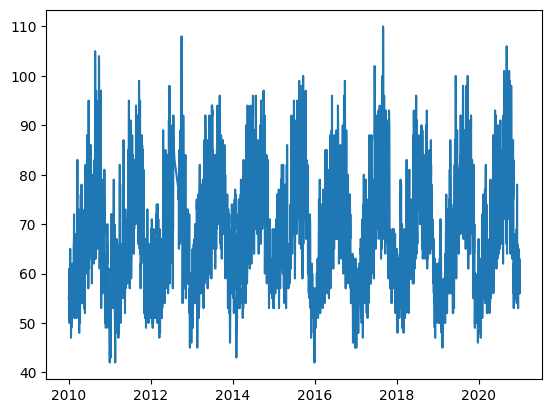

In [24]:
fig, ax = plt.subplots()
ax.plot(df["DATE"], df["TMAX_F"])

<bound method Axes.plot of <Axes: >>

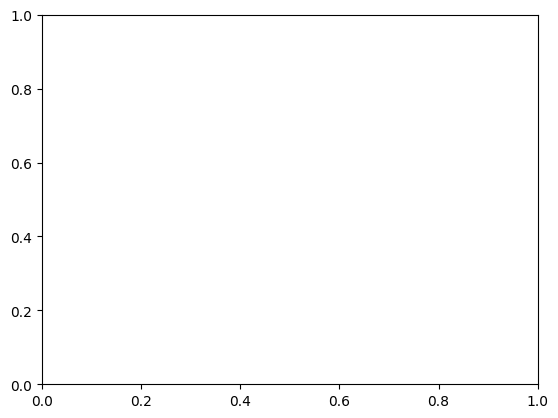

In [25]:
fig, ax = plt.subplots()
ax.plot

In [26]:
def create_sequences(data: pd.DataFrame, seq_length):
    # print(data)
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[["TMAX_F", "TMIN_F"]].values[i:i + seq_length]
        y = data[["TMAX_F", "TMIN_F"]].values[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(df, SEQ_LENGTH)
# print(X.shape)
# print(y.shape)

KeyboardInterrupt: 

In [ ]:
mean = X.mean()
std = X.std()

X_norm = (X - mean) / std

y_mean = y.mean()
y_std = y.std()
y_norm = (y - y_mean) / y_std

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = TimeSeriesDataset(X_norm, y_norm)

train_size = int((1 - VALIDATION_SPLIT) * len(dataset))
val_size = len(dataset) - train_size

# split dataset
dataset_train, dataset_val = random_split(dataset, [train_size, val_size])

dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
df_test = pd.read_csv("data/weather_daily_2024.csv")
df_test["DATE"] = pd.to_datetime(df_test["DATE"])

X_test, y_test = create_sequences(df_test, SEQ_LENGTH)

X_test_norm = (X_test - mean) / std
y_test_norm = (y_test - y_mean) / y_std

dataset_test = TimeSeriesDataset(X_test_norm, y_test_norm)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# *benchmark* just returns last val in sequence
class NaiveModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        # print(x.shape)
        # print(x)
        # return
        out = x[:, -1]
        return out
    
naive_model = NaiveModel()

In [ ]:
naive_predictions = naive_model(X_test)
naive_predictions.shape
type(naive_predictions)

numpy.ndarray

In [ ]:
# from statsmodels.tsa.arima.model import ARIMA

# origin, start_date, end_date = "2024-01-01", "2024-03-01", "2024-05-31"
# time_period = pd.date_range(start_date, end_date)
# df_test = df_test.set_index("DATE", drop=False).sort_index()
# series = df_test.loc[origin:end_date]["TMAX_F"].asfreq("D")


# y_preds = []
# for today in time_period.shift(-1):
#     print(today)
#     y_preds.append(1)
#     if len(y_preds)==5:
#         break
#     model = ARIMA(series[origin:today], order=(2, 0, 2), seasonal_order=(1, 0, 1, 365))
#     model = model.fit()
#     y_pred = model.forecast()[0]
#     y_preds.append(y_pred)

# y_preds = pd.Series(y_preds, index=time_period)
# mse = ((y_preds - series[time_period]) ** 2).mean()

36.75297619047619


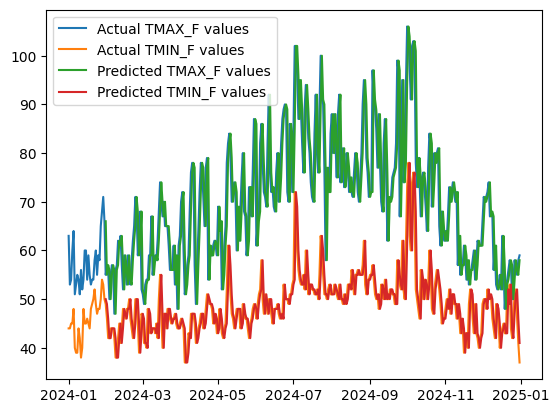

In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(df_test[["TMAX_F","TMIN_F"]].values[SEQ_LENGTH:], naive_predictions))

fig, ax = plt.subplots()
ax.plot(df_test["DATE"], df_test["TMAX_F"], label="Actual TMAX_F values")
ax.plot(df_test["DATE"], df_test["TMIN_F"], label="Actual TMIN_F values")
ax.plot(df_test[SEQ_LENGTH:]["DATE"], naive_predictions[:,0], label="Predicted TMAX_F values")
ax.plot(df_test[SEQ_LENGTH:]["DATE"], naive_predictions[:,1], label="Predicted TMIN_F values")
ax.legend()

In [ ]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, output_dim=OUTPUT_DIM):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=DROPOUT_RATE)
        self.linear = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out,_ = self.lstm(x)  
        out = out[:, -1, :]   
        # return output
        return self.linear(out)

model = LSTMModel()

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

trainingLossData = []
validationLossData = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for x_batch, y_batch in dataloader:
        # print("X:",x_batch.shape)
        # print("Y:",y_batch.shape)
        y_pred = model(x_batch)
        # print("prediction:",y_pred.shape)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(dataloader)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader_val:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    val_loss /= len(dataloader_val)

    trainingLossData.append(train_loss)
    validationLossData.append(val_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


Epoch 1, Training Loss: 0.4834, Validation Loss: 0.2881
Epoch 2, Training Loss: 0.2501, Validation Loss: 0.2694
Epoch 3, Training Loss: 0.2391, Validation Loss: 0.2577
Epoch 4, Training Loss: 0.2160, Validation Loss: 0.2306
Epoch 5, Training Loss: 0.1888, Validation Loss: 0.1902
Epoch 6, Training Loss: 0.1593, Validation Loss: 0.1803
Epoch 7, Training Loss: 0.1561, Validation Loss: 0.1909
Epoch 8, Training Loss: 0.1538, Validation Loss: 0.1763
Epoch 9, Training Loss: 0.1516, Validation Loss: 0.1756
Epoch 10, Training Loss: 0.1501, Validation Loss: 0.1753
Epoch 11, Training Loss: 0.1505, Validation Loss: 0.1736
Epoch 12, Training Loss: 0.1512, Validation Loss: 0.1745
Epoch 13, Training Loss: 0.1489, Validation Loss: 0.1716
Epoch 14, Training Loss: 0.1475, Validation Loss: 0.1755
Epoch 15, Training Loss: 0.1496, Validation Loss: 0.1711
Epoch 16, Training Loss: 0.1496, Validation Loss: 0.1758
Epoch 17, Training Loss: 0.1454, Validation Loss: 0.1705
Epoch 18, Training Loss: 0.1469, Validat

In [ ]:
test_predictions = np.empty((0, 2))

# print("Intial:",test_predictions.shape)

with torch.no_grad():
    for x_batch, y_batch in dataloader_test:
        # print("X:",x_batch.shape)
        # print("Y:",y_batch.shape)
        predictions = model(x_batch)
        # print("Prediction:",predictions.shape)
        predictions_np = predictions.view(-1).numpy()

        test_predictions = np.append(test_predictions, predictions_np)

    test_predictions = test_predictions.reshape(-1, 2)
    # print("final shape:",test_predictions.shape)
        

In [ ]:
print(test_predictions.shape)

(336, 2)


In [ ]:
df_test[12:]["DATE"].shape

(354,)

In [ ]:
test_predictions = test_predictions * y_std + y_mean

MSE Result: 158.93442812950974


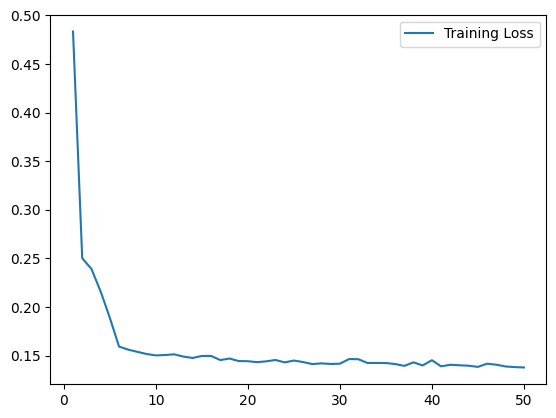

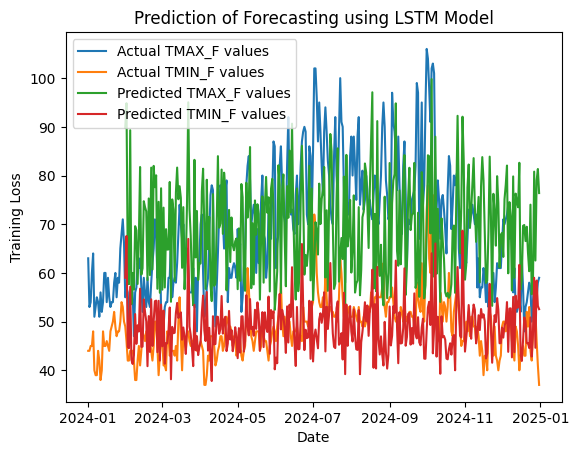

In [ ]:
# print(df_test[["TMAX_F","TMIN_F"]].values[SEQ_LENGTH:].shape)
# print(test_predictions.shape)

# MSE for both TMAX_F and TMIN_F
print("MSE Result:",mean_squared_error(df_test[["TMAX_F","TMIN_F"]].values[SEQ_LENGTH:], test_predictions))

# MSE for only TMAX_F (worse results)
# print("MSE Result:",mean_squared_error(df_test["TMAX_F"].values[SEQ_LENGTH:], test_predictions[:,0]))

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()

# Training Loss Graph
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
ax.plot(range(1,EPOCHS + 1),trainingLossData, label="Training Loss")
ax.plot(range(1, EPOCHS + 1), validationLossData, label="Validation Loss")
ax.legend()

plt.title("Prediction of Forecasting using LSTM Model")
plt.xlabel("Date")
ax2.plot(df_test["DATE"], df_test["TMAX_F"], label="Actual TMAX_F values")
ax2.plot(df_test["DATE"], df_test["TMIN_F"], label="Actual TMIN_F values")
ax2.plot(df_test[SEQ_LENGTH:]["DATE"], test_predictions[:,0], label="Predicted TMAX_F values")
ax2.plot(df_test[SEQ_LENGTH:]["DATE"], test_predictions[:,1], label="Predicted TMIN_F values")
ax2.legend()